## Notebook to apply sst binning to data from raman lidar
#### Author: Claudia Acquistapace
#### Date: 08/12/2021
#### Goal: reading data without diurnal cycle, filter out rainy time stamps and calculate mean profiles for each sst bin. The script then saves the variables binned on sst in a ncdf file. 

In [3]:
# importing necessary libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.dates as mdates
import glob
#from myFunctions import lcl
#from myFunctions import f_closest
from warnings import warn
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from scipy import interpolate
import custom_color_palette as ccp
from matplotlib import rcParams
import matplotlib.ticker as ticker


def f_interpolate_SST_and_merge(SST_DS, dataset_obs):
    '''function to interpolate SST values on the time resolution of the observations given as input
    input: 
    SST_DS: xarray dataset containing sst values
    dataset_obs: xarray dataset containing the observations to merge with sst data
    output: 
    data_merged: data returned 
    '''
    
    # interpolating sst data at 1 min resolution to the 10 s res of the wind lidar
    sst_data_interp = SST_DS.interp(time=dataset_obs['time'].values)

    # merging the interpolated dataset and the wind lidar dataset
    data_merged = xr.merge([dataset_obs, sst_data_interp])
    return(data_merged)


def f_calculate_binned_data(data_input, SST_binned_arr):
    
    ''' function to calculate mean values of all variables for each SST bin, for all instruments
    author: Claudia Acquistapace
    date: 20 Sept 2021
    input: - data_input: input xarray dataset containing the variables as a function of time, height, to be averaged
            - SST_binned_arr: numpy array of sst binned values for calculating the mean 
    output: dataset_concat: xarray dataset of concatenated values with mean profiles corresponding to the sst bins. A variable n_el counts the number of profiles averaged together
    '''
    # calculating mean quantities f
    dataset_mean = []

    data_input = data_input.load()

    # selecting all columns in the bin interval
    for ind_bin in range(len(SST_binned_arr)-1):

        # selecting slices of datasets columns with SST values in the selected bin
        DS_sliced = data_merged.where((data_input.SST > SST_binned_arr[ind_bin]) & (data_input.SST < SST_binned_arr[ind_bin+1]), drop=True)

        # add variable of the number of elements of the slice
        n_el = len(DS_sliced.SST.values)
        DS_sliced['n_elements'] = n_el

        # calculate mean profile averaging all selected time stamps together
        dataset_mean.append(DS_sliced.mean(dim='time', skipna=True))


    # concatenating datasets corresponding to SST bins on a new bin dimension
    dataset_concat = xr.concat([dataset_mean[i] for i in np.arange(len(dataset_mean))], dim='SST_binned')
    return(dataset_concat)




dict_plot_settings = {
    'labelsizeaxes':14,
    'fontSizeTitle':16,
    'fontSizeX'    :16,
    'fontSizeY'    :16,
    'cbarAspect'   :10,
    'fontSizeCbar' :16,
    'rcparams_font':['Tahoma'],
    'savefig_dpi'  :100,
    'font_size'    :22, 
    'grid'         :True}




data_path = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/diurnal_cycle_removed/'
tsg_file = "/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/tsg_sst_data/tsg/nc/msm_089_1_tsg.nc"
path_out_plots = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/plots_paper/'


In [4]:
# reading tsg file ( data with 1 min resolution)
tsg_data = xr.open_dataset(tsg_file)

In [5]:
tsg_data.TIME.values[0:3]

array(['2020-01-17T00:00:55.000003328', '2020-01-17T00:01:54.999999744',
       '2020-01-17T00:02:54.999996160'], dtype='datetime64[ns]')

reading data from tsg and create SST dataset

In [6]:
# reading data containing flags to filter out rainy columns
flag_file_list = np.sort(glob.glob('/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/*_flags_cloud_properties.nc'))
flag_file_list = flag_file_list[13:15]

flag_data = xr.open_mfdataset(flag_file_list)

In [7]:
# reading tsg file ( data with 1 min resolution)
tsg_data = xr.open_dataset(tsg_file)

# identifying time stamps of sst corresponding to time stamps of radiosondes
t_start = datetime(2020, 2, 2, 0, 0, 0)
t_end = datetime(2020, 2, 3, 23, 59, 59)

# slicing tsg datase t for the selected time interval and extracting sst
sliced_tsg_ds = tsg_data.sel(TIME=slice(t_start, t_end))
tsg_sst = sliced_tsg_ds['TEMP'].values
tsg_time_sst = sliced_tsg_ds['TIME'].values
tsg_flag = sliced_tsg_ds['TEMP_QC'].values

# averaging together the sst of the different sst sensors for tsg
temp0 = sliced_tsg_ds.TEMP[:,0].values
temp1 = sliced_tsg_ds.TEMP[:,1].values
sst_tsg = temp0
sst_tsg[np.isnan(temp0)] = temp1[np.isnan(temp0)]

# producing output dataset of sst_tsg for the selected time window
# creating dataset with coordinates sst and height
dim_sst           = ['time']
coords         = {"time":sliced_tsg_ds.TIME.values}
SST              = xr.DataArray(dims=dim_sst, coords=coords, data=sst_tsg,
                 attrs={'long_name':'sea surface temperature ',
                        'units':'$^{\circ}$C'})
variables         = {'SST':SST}
SST_DS      = xr.Dataset(data_vars = variables,
                       coords = coords)


definition of the functions for: 
- Interpolation of the SST on the time grid of each instrument
- binning of the data over SST grid


In [8]:
# building SST binned array
SST_min = np.nanmin(sst_tsg)
SST_max = np.nanmax(sst_tsg)
SST_binned_arr = np.arange(SST_min, SST_max, step=0.025)


# calculate label marks for bins
sst_bin_label = []
for ind in range(len(SST_binned_arr)-1):
    sst_bin_label.append(round((SST_binned_arr[ind]+SST_binned_arr[ind+1])/2,2))
    


In [10]:
a = np.ones((4,3))
a[2,0]= np.nan
print(a)
print(np.count_nonzero(~np.isnan(a), axis=0))

data_path

[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [nan  1.  1.]
 [ 1.  1.  1.]]
[3 4 4]


'/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/diurnal_cycle_removed/'

Reading data from Arthus for T, wvmr, SHF, LHF.

In [14]:
# reading all arthus data 

# variable list
var_list =['T','WVMR','VW','LHF','SHF']

T_dict = {
     'var_name'  : 'T',
     'var_string': 'Temperature',
     'var_units' : ' $^{\circ}$K',
     'var_min'   : 290.,
     'var_max'   : 310.,
     'thr_min'   : 280.,
     'thr_max'   : 330.,
     'avg_time'  : '15',
     'cmap'      : 'jet',
     'title'     : 'Air temperature: 28/01-04/02'}

WVMR_dict = {
     'var_name'  : 'MR',
     'var_string': 'Water vapor mixing ratio',
     'var_units' : ' g kg$^{-1}$',
     'var_min'   : 0.,
     'var_max'   : 30.,
     'thr_min'   : 0.,
     'thr_max'   : 30.,
     'avg_time'  : '15',
     'cmap'      : 'jet',
     'title'     : 'Water vapor mixing ratio: 28/01-04/02'}

VW_dict = {
     'var_name'  : 'VW',
     'var_string': 'Vertical velocity',
     'var_units' : ' ms$^{-1}$',
     'var_min'   : -2.,
     'var_max'   : 2.,
     'thr_min'   : -5.,
     'thr_max'   : 5.,
     'avg_time'  : '15',
     'cmap'      : 'seismic',
     'title'     : 'Vertical velocity: 28/01-04/02'}

LHF_dict = {
     'var_name'  : 'LHF',    
     'var_string': 'Latent heat flux',
     'var_units' : ' W m$^{-2}$',
     'var_min'   : -250.,
     'var_max'   : 250.,
     'thr_min'   : -250.,
     'thr_max'   : 250.,
     'avg_time'  : '30',
     'cmap'      : 'jet',
     'title'     : 'Latent heat flux: 28/01-04/02'}

SHF_dict = {
     'var_name'  : 'SHF',
     'var_string': 'Sensible heat flux',
     'var_units' : ' W m$^{-2}$',
     'var_min'   : -100.,
     'var_max'   : 100.,
     'thr_min'   : -100.,
     'thr_max'   : 100.,
     'avg_time'  : '30',
     'cmap'      : 'jet',
     'title'     : 'Sensible heat flux: 28/01-04/02'}

theta_dict = {
     'var_name'  : 'theta',
     'var_string': 'potential temperature',
     'var_units' : '$K$',
     'var_min'   : 290.,
     'var_max'   : 310.,
     'thr_min'   : 290.,
     'thr_max'   : 310.,
     'avg_time'  : '15',
     'cmap'      : 'jet',
     'title'     : 'Potential temperature: 28/01-04/02'}

theta_e_dict = {
     'var_name'  : 'theta_e',
     'var_string': 'equivalent potential temperature',
     'var_units' : '$K$',
     'var_min'   : 290.,
     'var_max'   : 360.,
     'thr_min'   : 290.,
     'thr_max'   : 360.,
     'avg_time'  : '15',
     'cmap'      : 'jet',
     'title'     : 'Equivalent potential temperature: 28/01-04/02'}
dict_list = [T_dict, WVMR_dict, VW_dict, LHF_dict, SHF_dict, theta_dict, theta_e_dict]
#dict_list = [theta_dict, theta_e_dict]


vars_arthus = []

for i_var, dict_var in enumerate(dict_list):

    print('processing variable: ', dict_var['var_string'])
    print(data_path+dict_var['var_name']+'*.nc')
    
    # reading file list of the files for the selected variable
    arthus_file_list = np.sort(glob.glob(data_path+dict_var['var_name']+'_2020*.nc'))
    print(arthus_file_list)
    
    # read the two datasets together
    arthus_dataset = xr.open_mfdataset(arthus_file_list)
    
    # renaming variable time and height and dimension time and height (step necessary for next operations)
    #arthus_dataset = arthus_dataset.rename_dims({'Time':'time'})
    #arthus_dataset = arthus_dataset.rename_dims({'Height':'height'})
    #arthus_dataset = arthus_dataset.rename_vars({'Time':'time'})
    #arthus_dataset = arthus_dataset.rename_vars({'Height':'height'})

    print('files read')

    # interpolate flag on time resolution of arthus data, picking the closest time stamp to lidar time stamps
    flag_data_interp = flag_data.interp(time=arthus_dataset['time'].values, method='nearest')

    print('flag interpolated')
    
    # building a mask to filter out Ze rainy columns and substitute them with nans
    # set to nan the values out of the thresholds for the selected variable
    mask = np.zeros((len(arthus_dataset.time.values), len(arthus_dataset.height.values)))
    for ind in range(len(flag_data_interp.time.values)):
        if (flag_data_interp["flag_rain_ground"].values[ind] == 1) | (flag_data_interp["flag_rain"].values[ind] == 1):
            mask[ind,:] = np.repeat(1, len(arthus_dataset.height.values))

    print('mask calculated')
    
    arthus_dataset["nans"] = xr.full_like(arthus_dataset.product_no_diurnal_cycle, fill_value=np.nan)
    arthus_dataset['product_no_diurnal_cycle'] = xr.where(mask == 0, arthus_dataset['product_no_diurnal_cycle'], arthus_dataset["nans"])

    
    # interpolating SST data on the arthus data 
    arthus_all_SST = f_interpolate_SST_and_merge(SST_DS, arthus_dataset)
    print(arthus_all_SST)
    
    
    
    print('interpolation and merging done')

    # calculating mean quantities for each bin
    dataset_mean = []
    dataset_std = []
    dataset_n = []
    
    # selecting all columns in the bin interval
    for ind_bin in range(len(SST_binned_arr)-1):

        # selecting slices of datasets columns with SST values in the selected bin
        DS_sliced = arthus_all_SST.where((arthus_all_SST.SST > SST_binned_arr[ind_bin]) & (arthus_all_SST.SST < SST_binned_arr[ind_bin+1]), drop=True)

        # add variable of the number of elements of the slice
        n_el = len(DS_sliced.SST.values)
        
        # add variable of absolute value of the var
        dims_ds = ['time','height']
        coords_ds = {'time':DS_sliced['time'].values, 'height':DS_sliced['height'].values}
        abs_val = np.abs(DS_sliced['product_no_diurnal_cycle'].values)
        DS_sliced['abs_val'] =  xr.DataArray(dims=dims_ds, coords=coords_ds, data=abs_val)

    
        # add variable of count of values for each sliced dataset where we calculate mean/std 
        dims_ds = ['time','height']
        coords_ds = {'time':DS_sliced['time'].values, 'height':DS_sliced['height'].values}
        counts = np.count_nonzero(~np.isnan(DS_sliced['product_no_diurnal_cycle'].values), axis=0)
        #print(np.shape(counts))
        #print(counts)
        DS_sliced['n_elements'] =  xr.DataArray(dims=['height'], \
                                                coords={'height':DS_sliced['height'].values}, \
                                                data=counts, 
                                               attrs={'long_name':'number of values in each bin SST/height'})        
        
        
        # calculate mean profile averaging all selected time stamps together
        dataset_mean.append(DS_sliced.mean(dim='time', skipna=True))
        dataset_std.append(DS_sliced.std(dim='time', skipna=True))
        dataset_n.append(DS_sliced['n_elements'])
        
        
    # concatenating datasets corresponding to SST bins on a new bin dimension
    arthus_SST_concat = xr.concat([dataset_mean[i] for i in np.arange(len(dataset_mean))], dim='SST_binned')
    arthus_SST_std_concat = xr.concat([dataset_std[i] for i in np.arange(len(dataset_std))], dim='SST_binned')
    arthus_SST_n_concat = xr.concat([dataset_n[i] for i in np.arange(len(dataset_n))], dim='SST_binned')
    
    
    # saving variable of interest in a dictionary with its name: for vertical velocity (VW) we save the absolute value
    # of vertical velocity for mean variable, and the std of the vertical velocity values.
    if dict_var['var_name']!= 'VW':
        dict_variable_nodc = {'var_name':dict_var['var_name'],
                     'var':arthus_SST_concat['product_no_diurnal_cycle'].values, 
                     'std':arthus_SST_std_concat['product_no_diurnal_cycle'].values,
                      'n':arthus_SST_n_concat.data}
    else:
        dict_variable_nodc = {'var_name':dict_var['var_name'],
                     'var':arthus_SST_concat['abs_val'].values, 
                     'std':arthus_SST_std_concat['product_no_diurnal_cycle'].values,
                      'n':arthus_SST_n_concat.data}       
    
    
    # append the dictionary in a list of dictionaries containing all arthus variables
    vars_arthus.append(dict_variable_nodc)


processing variable:  Temperature
/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/diurnal_cycle_removed/T*.nc
['/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/diurnal_cycle_removed/T_20200202.nc'
 '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/diurnal_cycle_removed/T_20200203.nc']
files read
flag interpolated
mask calculated
<xarray.Dataset>
Dimensions:                   (height: 57, time: 16617)
Coordinates:
  * time                      (time) datetime64[ns] 2020-02-02T00:00:08 ... 2...
  * height                    (height) float32 225.0 275.0 ... 2975.0 3025.0
Data variables:
    product_no_diurnal_cycle  (time, height) float64 dask.array<chunksize=(8438, 57), meta=np.ndarray>
    product_no_noise          (time, height) float64 dask.array<chunksize=(8438, 57), meta=np.ndarray>
    nans                      (time, height) float64 dask.array<chunksize=(8438, 57), meta=np.ndarray>
    S

/Users/claudia/opt/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


processing variable:  Water vapor mixing ratio
/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/diurnal_cycle_removed/MR*.nc
['/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/diurnal_cycle_removed/MR_20200202.nc'
 '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/diurnal_cycle_removed/MR_20200203.nc']
files read
flag interpolated
mask calculated
<xarray.Dataset>
Dimensions:                   (height: 57, time: 16617)
Coordinates:
  * time                      (time) datetime64[ns] 2020-02-02T00:00:08 ... 2...
  * height                    (height) float32 225.0 275.0 ... 2975.0 3025.0
Data variables:
    product_no_diurnal_cycle  (time, height) float64 dask.array<chunksize=(8438, 57), meta=np.ndarray>
    product_no_noise          (time, height) float64 dask.array<chunksize=(8438, 57), meta=np.ndarray>
    nans                      (time, height) float64 dask.array<chunksize=(8438, 57), meta=n

/Users/claudia/opt/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


processing variable:  Vertical velocity
/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/diurnal_cycle_removed/VW*.nc
['/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/diurnal_cycle_removed/VW_20200202.nc'
 '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/diurnal_cycle_removed/VW_20200203.nc']
files read
flag interpolated
mask calculated
<xarray.Dataset>
Dimensions:                   (height: 57, time: 16617)
Coordinates:
  * time                      (time) datetime64[ns] 2020-02-02T00:00:08 ... 2...
  * height                    (height) float32 225.0 275.0 ... 2975.0 3025.0
Data variables:
    product_no_diurnal_cycle  (time, height) float64 dask.array<chunksize=(8438, 57), meta=np.ndarray>
    product_no_noise          (time, height) float64 dask.array<chunksize=(8438, 57), meta=np.ndarray>
    nans                      (time, height) float64 dask.array<chunksize=(8438, 57), meta=np.ndarr

/Users/claudia/opt/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


processing variable:  Latent heat flux
/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/diurnal_cycle_removed/LHF*.nc
['/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/diurnal_cycle_removed/LHF_20200202.nc'
 '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/diurnal_cycle_removed/LHF_20200203.nc']
files read
flag interpolated
mask calculated
<xarray.Dataset>
Dimensions:                   (height: 57, time: 16618)
Coordinates:
  * time                      (time) datetime64[ns] 2020-02-02T00:00:08 ... 2...
  * height                    (height) float32 225.0 275.0 ... 2975.0 3025.0
Data variables:
    product_no_diurnal_cycle  (time, height) float64 dask.array<chunksize=(8438, 57), meta=np.ndarray>
    product_no_noise          (time, height) float64 dask.array<chunksize=(8438, 57), meta=np.ndarray>
    nans                      (time, height) float64 dask.array<chunksize=(8438, 57), meta=np.nda

/Users/claudia/opt/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


processing variable:  Sensible heat flux
/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/diurnal_cycle_removed/SHF*.nc
['/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/diurnal_cycle_removed/SHF_20200202.nc'
 '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/diurnal_cycle_removed/SHF_20200203.nc']
files read
flag interpolated
mask calculated
<xarray.Dataset>
Dimensions:                   (height: 57, time: 16618)
Coordinates:
  * time                      (time) datetime64[ns] 2020-02-02T00:00:08 ... 2...
  * height                    (height) float32 225.0 275.0 ... 2975.0 3025.0
Data variables:
    product_no_diurnal_cycle  (time, height) float64 dask.array<chunksize=(8438, 57), meta=np.ndarray>
    product_no_noise          (time, height) float64 dask.array<chunksize=(8438, 57), meta=np.ndarray>
    nans                      (time, height) float64 dask.array<chunksize=(8438, 57), meta=np.n

/Users/claudia/opt/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


processing variable:  potential temperature
/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/diurnal_cycle_removed/theta*.nc
['/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/diurnal_cycle_removed/theta_20200202.nc'
 '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/diurnal_cycle_removed/theta_20200203.nc']
files read
flag interpolated
mask calculated
<xarray.Dataset>
Dimensions:                   (height: 57, time: 16617)
Coordinates:
  * time                      (time) datetime64[ns] 2020-02-02T00:00:08 ... 2...
  * height                    (height) float64 225.0 275.0 ... 3.025e+03
Data variables:
    product_no_diurnal_cycle  (time, height) float64 dask.array<chunksize=(8438, 57), meta=np.ndarray>
    product_no_noise          (time, height) float64 dask.array<chunksize=(8438, 57), meta=np.ndarray>
    nans                      (time, height) float64 dask.array<chunksize=(8438, 57), meta

/Users/claudia/opt/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


processing variable:  equivalent potential temperature
/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/diurnal_cycle_removed/theta_e*.nc
['/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/diurnal_cycle_removed/theta_e_20200202.nc'
 '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/diurnal_cycle_removed/theta_e_20200203.nc']
files read
flag interpolated
mask calculated
<xarray.Dataset>
Dimensions:                   (height: 57, time: 16617)
Coordinates:
  * time                      (time) datetime64[ns] 2020-02-02T00:00:08 ... 2...
  * height                    (height) float64 225.0 275.0 ... 3.025e+03
Data variables:
    product_no_diurnal_cycle  (time, height) float64 dask.array<chunksize=(8438, 57), meta=np.ndarray>
    product_no_noise          (time, height) float64 dask.array<chunksize=(8438, 57), meta=np.ndarray>
    nans                      (time, height) float64 dask.array<chunksize

/Users/claudia/opt/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [13]:
arthus_file_list
data_path

'/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/diurnal_cycle_removed/'

Saving all produced data in a ncdf file

In [15]:
# converting the list of dictionaries in a dictionary called variables to be saved in ncdf
dims             = ['sst','height']
coords           = {'sst':SST_binned_arr[0:-1], 'height':arthus_SST_concat['height'].values}
variables = {}
for i in range(len(dict_list)):
    key = vars_arthus[i]['var_name']
    value = xr.DataArray(dims=dims, coords=coords, data=vars_arthus[i]['var'],
                             attrs={'long_name':vars_arthus[i]['var_name']+' without diurnal cycle',
                                    'units':dict_var['var_units']})
    value_std = xr.DataArray(dims=dims, coords=coords, data=vars_arthus[i]['std'],
                             attrs={'long_name':'std of '+vars_arthus[i]['var_name']+' without diurnal cycle',
                                    'units':dict_var['var_units']})
    value_n = xr.DataArray(dims=dims, coords=coords, data=vars_arthus[i]['n'],
                             attrs={'long_name':'number of '+vars_arthus[i]['var_name']+' values in the bin',
                                    'units':'#'})
    variables[key] = value
    variables[key+'_std'] = value_std
    variables[key+'_n'] = value_n


global_attributes = {'CREATED_BY'       : 'Claudia Acquistapace',
                        'CREATED_ON'       :  str(datetime.now()),
                        'FILL_VALUE'       :  'NaN', 
                        'PI_NAME'          : 'Claudia Acquistapace',
                        'PI_AFFILIATION'   : 'University of Cologne (UNI), Germany', 
                        'PI_ADDRESS'       : 'Institute for geophysics and meteorology, Pohligstrasse 3, 50969 Koeln', 
                        'PI_MAIL'          : 'cacquist@meteo.uni-koeln.de',
                        'DATA_DESCRIPTION' : dict_var['var_string']+'with the diurnal cycle removed from the data',
                        'DATA_DISCIPLINE'  : 'Atmospheric Physics - Remote Sensing Lidar Profiler',
                        'DATA_GROUP'       : 'Experimental;Profile;Moving',
                        'DATA_SOURCE'      : 'arthus data',
                        'DATA_PROCESSING'  : 'https://github.com/ClauClouds/SST-impact/',
                        'INSTRUMENT_MODEL' : 'arthus raman lidar system',
                         'COMMENT'         : 'original data postprocessed by Diego Lange' }
dataset_out    = xr.Dataset(data_vars = variables,
                        coords = coords,
                        attrs = global_attributes)
dataset_out.to_netcdf('/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/binned_sst/arthus_binned_sst_4.nc')


(250.0, 1000.0)

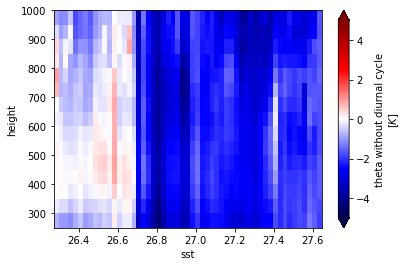

In [16]:
dataset_out.theta.plot(x='sst', y='height', vmin=-5, vmax=5, cmap='seismic')
plt.ylim(250., 1000)

(250.0, 1000.0)

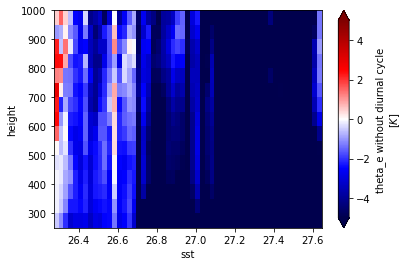

In [17]:
dataset_out.theta_e.plot(x='sst', y='height', vmin=-5, vmax=5, cmap='seismic')
plt.ylim(250., 1000)

In [22]:
vars_arthus[1]

{'var_name': 'theta_e',
 'var': array([[ -0.64798992,  -0.84050552,  -0.45893688, ...,          nan,
                  nan,          nan],
        [ -0.99090581,  -1.43693559,  -0.82064648, ...,          nan,
                  nan,          nan],
        [ -2.16132819,  -2.38588664,  -1.51049098, ...,          nan,
                  nan,          nan],
        ...,
        [ -3.96799127,  -3.65534377,  -3.50059602, ..., -10.93554471,
                  nan,          nan],
        [ -3.80446444,  -3.75140273,  -3.47996795, ..., -15.85101273,
                  nan,          nan],
        [ -3.92025649,  -4.1985085 ,  -3.490507  , ..., -17.41292403,
                  nan,          nan]]),
 'std': array([[1.50183511, 1.53806827, 1.58305103, ...,        nan,        nan,
                nan],
        [1.2716837 , 1.10719572, 0.8986584 , ...,        nan,        nan,
                nan],
        [1.19288762, 1.20087875, 1.15135231, ...,        nan,        nan,
                nan],
        ...

NameError: name 'sst_bin_label_cf' is not defined

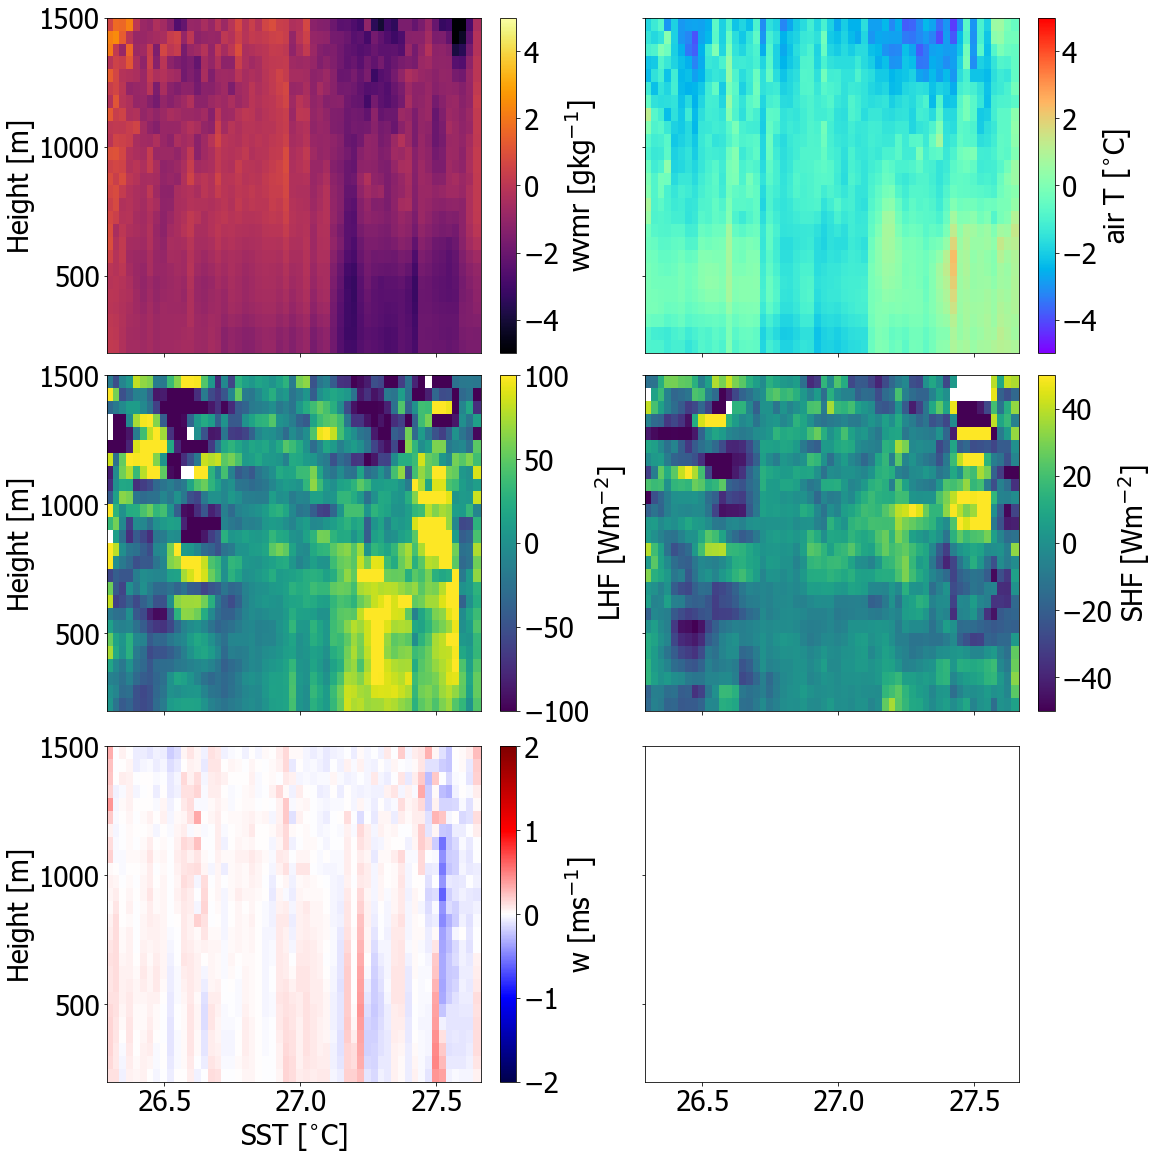

In [7]:
dict_plot_settings = {
    'labelsizeaxes':14,
    'fontSizeTitle':16,
    'fontSizeX'    :28,
    'fontSizeY'    :28,
    'cbarAspect'   :10,
    'fontSizeCbar' :28,
    'rcparams_font':['Tahoma'],
    'savefig_dpi'  :100,
    'font_size'    :28, 
    'grid'         :True}


# composite figure variables binned in sst 
path_out_plots = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/plots/'

# plots settings defined by user at the top
labelsizeaxes   = dict_plot_settings['labelsizeaxes']
fontSizeTitle   = dict_plot_settings['fontSizeTitle']
fontSizeX       = dict_plot_settings['fontSizeX']
fontSizeY       = dict_plot_settings['fontSizeY']
cbarAspect      = dict_plot_settings['cbarAspect']
fontSizeCbar    = dict_plot_settings['fontSizeCbar']
rcParams['font.sans-serif'] = dict_plot_settings['rcparams_font']
matplotlib.rcParams['savefig.dpi'] = dict_plot_settings['savefig_dpi']
plt.rcParams.update({'font.size':dict_plot_settings['font_size']})
grid = dict_plot_settings['grid']

fig, axs = plt.subplots(3, 2, figsize=(16,16), sharey=True, sharex=True, constrained_layout=True)

green_diamond = dict(markerfacecolor='b', marker='D')

mesh = axs[0,0].pcolormesh(sst_bin_label, dataset_out.height.values, dataset_out.MR.values.T, cmap='inferno', vmin=-5., vmax=5)
cbar = fig.colorbar(mesh, ax=axs[0,0])
cbar.set_label(label='wvmr [gkg$^{-1}$]',  size=fontSizeX)
axs[0,0].set_ylabel('Height [m]', fontsize=fontSizeX)
axs[0,0].set_ylim(200,1500)

mesh = axs[0,1].pcolormesh(sst_bin_label, dataset_out.height.values, dataset_out.T.values.T, cmap='rainbow', vmin=-5., vmax=5.)
cbar = fig.colorbar(mesh, ax=axs[0,1])
cbar.set_label(label='air T [$^{\circ}$C]',  size=fontSizeX)
axs[0,1].set_ylim(200,1500)

mesh = axs[1,0].pcolormesh(sst_bin_label, dataset_out.height.values, dataset_out.LHF.values.T, cmap='viridis', vmin=-100., vmax=100.)
cbar = fig.colorbar(mesh, ax=axs[1,0])
cbar.set_label(label='LHF [Wm$^{-2}$]',  size=fontSizeX)
axs[1,0].set_ylabel('Height [m]', fontsize=fontSizeX)
axs[1,0].set_ylim(200,1500)

mesh = axs[1,1].pcolormesh(sst_bin_label, dataset_out.height.values, dataset_out.SHF.values.T, cmap='viridis', vmin=-50., vmax=50.)
cbar = fig.colorbar(mesh, ax=axs[1,1])
cbar.set_label(label='SHF [Wm$^{-2}$]', size=fontSizeX)
axs[1,1].set_ylim(200,1500)


mesh = axs[2,0].pcolormesh(sst_bin_label, dataset_out.height.values, dataset_out.VW.values.T, cmap='seismic', vmin=-2., vmax=2.)
cbar = fig.colorbar(mesh, ax=axs[2,0])
cbar.set_label(label='w [ms$^{-1}$]',  size=fontSizeX)
axs[2,0].set_ylabel('Height [m]', fontsize=fontSizeX)
axs[2,0].set_xlabel('SST [$^{\circ}$C]', fontsize=fontSizeX)



mesh = axs[2,1].pcolormesh(sst_bin_label_cf, cloud_fraction_concat.height.values, cloud_fraction_concat.cloud_fraction.values.T, cmap='binary', vmin=0., vmax=0.5)
cbar = fig.colorbar(mesh, ax=axs[2,1])
cbar.set_label(label='cloud fraction []',  size=fontSizeX)
axs[2,1].set_xlabel('SST [$^{\circ}$C]', fontsize=fontSizeX)


count = 0
for ax, l in zip(axs[:].flatten(), ['(a) ',  '(b) ',  '(c) ',  '(d) ', '(e) ', '(f) ']):
    ax.text(-0.05, 1.1, l,  fontweight='black', fontsize=fontSizeX, transform=ax.transAxes)
    #ax.set_xlim(SST_binned_arr[0]-0.1, SST_binned_arr[-1]+0.1)
    
    ax.set_ylim(250.,1500.)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_linewidth(3)
    ax.spines["left"].set_linewidth(3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(which='minor', length=5, width=2)
    ax.tick_params(which='major', length=7, width=3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(axis='both', labelsize=26)
    #ax.grid(True, which='both', color='grey', linestyle=':')
    count = count+1
fig.savefig(path_out_plots+'profile_lidars_binned_sst.png')